## Importation des librairies et des données

In [69]:
# Importation des librairies
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, calinski_harabasz_score, adjusted_mutual_info_score, homogeneity_score, completeness_score
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

## Paramètres

In [70]:
FILE_PATH = "data/Star39552_balanced.csv"
RANDOM_SEED = 42
SAMPLE_SIZE = 4000

# 1. Prétraitement et visualisation
## Importation des données

In [71]:
# Importation des données
data = pd.read_csv(FILE_PATH)

In [72]:
# Visualisation des données
data

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,10.00,31.66,6.19,1.213,K7V,22.502556,1
1,8.26,3.21,1.00,1.130,K0III,15.792525,0
2,8.27,12.75,1.06,0.596,F9V,18.797552,1
3,6.54,5.23,0.76,1.189,K1III,15.132508,0
4,8.52,0.96,0.72,0.173,B8V,13.431356,1
...,...,...,...,...,...,...,...
39547,5.83,0.17,0.52,0.474,B7Iab,6.982245,0
39548,7.05,18.12,0.92,0.424,F5V,18.340790,1
39549,9.21,3.89,1.46,0.227,A1IV,17.159748,1
39550,9.01,2.13,1.46,1.467,M5III,15.651898,0


In [5]:
# Vérification si valeurs manquantes
data.isnull().values.any()

False

Les données représentes différentes caractéristiques et une classification d'étoiles observées. Elles comportent 39'552 observations et 7 variables

**Variables** :
- **Vmag** (numérique) : Magnitude apparente de l’étoile
- **Plx** (numérique) : Distance entre l’étoile et la Terre
- **e_Plx** (numérique) : Erreur type de Plx
- **B-V** (numérique) : Indice couleur B-V
- **SdType** (catégorielle) : Type spectral
- **Amag** (numérique) : Magnitude absolue de l’étoile
- **TargetClass** (catégorielle) : 0 pour naine, 1 pour géante

La variable à prédire est la "TargetClass", le but est de pouvoir déterminer si une étoile est naine ou géante en fonction des autres variables

**Source:**
Wing-Fung Ku. (2020). *Star Dataset for Stellar Classification* [Data set]. Kaggle. [https://doi.org/10.34740/KAGGLE/DSV/1433961](https://doi.org/10.34740/KAGGLE/DSV/1433961)

Les lignes avec une erreur trop grandes sont enlevées

In [6]:
# Enlver les lignes avec une erreur (e_Plx) trop grande
data = data[data['e_Plx'] < 1]
print(data.shape)
data['TargetClass'].value_counts()

(20211, 7)


TargetClass
0    11328
1     8883
Name: count, dtype: int64

Pour avoir une durée d'éxécution pas trop longue, les données sont réduites à un échantilon

In [7]:
data = resample(data, replace = False ,n_samples = SAMPLE_SIZE, random_state= RANDOM_SEED)
print(data['TargetClass'].value_counts())
data

TargetClass
0    2227
1    1773
Name: count, dtype: int64


,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
10627,6.41,1.01,0.78,1.257,G5Ib,11.431606,0
19388,7.01,2.58,0.83,0.153,A2III,14.068098,0
34684,8.59,2.76,0.85,1.042,G8III,15.794546,0
3466,7.36,4.25,0.72,0.993,K0III,15.501945,0
6609,7.09,3.50,0.85,1.645,M3III:,14.810341,0
...,...,...,...,...,...,...,...
8828,6.51,3.85,0.52,-0.071,B9III,14.437304,0
28926,6.96,3.65,0.99,1.478,K3/K4III,14.771465,0
8458,6.17,4.41,0.87,1.344,K3III,14.392193,0
22996,6.60,3.15,0.90,1.707,M2III,14.091553,0


## Séparation des données en entrées et sortie

In [8]:
# Séparation des données en entrées et sortie
# Entrées
X = data.drop(['TargetClass', 'e_Plx'], axis = 1)
print(X)

# Sorties
y = data['TargetClass']
print(y)

       Vmag   Plx    B-V    SpType       Amag
10627  6.41  1.01  1.257      G5Ib  11.431606
19388  7.01  2.58  0.153     A2III  14.068098
34684  8.59  2.76  1.042     G8III  15.794546
3466   7.36  4.25  0.993     K0III  15.501945
6609   7.09  3.50  1.645    M3III:  14.810341
...     ...   ...    ...       ...        ...
8828   6.51  3.85 -0.071     B9III  14.437304
28926  6.96  3.65  1.478  K3/K4III  14.771465
8458   6.17  4.41  1.344     K3III  14.392193
22996  6.60  3.15  1.707     M2III  14.091553
10857  8.49  3.58  1.261     K1III  16.259415

[4000 rows x 5 columns]
10627    0
19388    0
34684    0
3466     0
6609     0
        ..
8828     0
28926    0
8458     0
22996    0
10857    0
Name: TargetClass, Length: 4000, dtype: int64


## Encodage de la variable HarvardType

In [9]:
X['SpType'].value_counts()

SpType
K0III      308
K1III      180
K2III      165
G8III      161
K3III      119
          ... 
B9Vp...      1
F8Vw         1
G8/K0II      1
F2Iavar      1
B1.5III      1
Name: count, Length: 744, dtype: int64

Le type spectral (SpType) comporte plus beaucoup d'instances différentes, ce qui donnera trop de variable en utilisant un *One Hot Encoder*, il faut séparer les compsantes de la *Harvard spectral classification* : la première composante est la première lettre qui représente le type d'étoile, la deuxième composante est un nombre entre 0 et 9 qui représente les subdivions du type (en focntion de la température). Plus d'inforamtion sur la classifiaction spectral peuvent être trouvé sur [la page wikipedia du type spectral](https://fr.wikipedia.org/wiki/Type_spectral)

In [10]:
# Simplification de la variable SpType
# Harvard Type
X['HarvardType'] = X['SpType'].str[0] # Extraire premier caractère
print(X['HarvardType'].value_counts())

# Harvard Sub Type
X['HarvardSubType'] = X['SpType'].apply(lambda x: int(re.search(r'\d', x).group()) if re.search(r'\d', x) else None) # Extraire le premier chiffre
X['HarvardSubType'] = X['HarvardSubType'].fillna(X['HarvardSubType'].mean()) # Remplacer les valeurs manquantes par la moyenne
print(X['HarvardSubType'].value_counts())

X = X.drop(['SpType'], axis = 1)

HarvardType
K    1287
G     661
F     647
B     630
A     522
M     241
O       6
C       5
W       1
Name: count, dtype: int64
HarvardSubType
0.000000    748
2.000000    602
8.000000    511
3.000000    484
1.000000    463
5.000000    401
9.000000    240
4.000000    207
6.000000    186
7.000000    156
3.603802      2
Name: count, dtype: int64


In [11]:
# Encodage de la variable HarvardType
encoder_onehot = OneHotEncoder(dtype = 'int')
type_encoded = encoder_onehot.fit_transform(X[['HarvardType']]).toarray()
type_encoded_df = pd.DataFrame(type_encoded, columns=encoder_onehot.get_feature_names_out(['HarvardType']))

X.reset_index(drop=True, inplace=True)

X = pd.concat([X, type_encoded_df], axis=1)
X= X.drop(['HarvardType'], axis = 1)
X

,Vmag,Plx,B-V,Amag,HarvardSubType,HarvardType_A,HarvardType_B,HarvardType_C,HarvardType_F,HarvardType_G,HarvardType_K,HarvardType_M,HarvardType_O,HarvardType_W
0,6.41,1.01,1.257,11.431606,5.0,0,0,0,0,1,0,0,0,0
1,7.01,2.58,0.153,14.068098,2.0,1,0,0,0,0,0,0,0,0
2,8.59,2.76,1.042,15.794546,8.0,0,0,0,0,1,0,0,0,0
3,7.36,4.25,0.993,15.501945,0.0,0,0,0,0,0,1,0,0,0
4,7.09,3.50,1.645,14.810341,3.0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,6.51,3.85,-0.071,14.437304,9.0,0,1,0,0,0,0,0,0,0
3996,6.96,3.65,1.478,14.771465,3.0,0,0,0,0,0,1,0,0,0
3997,6.17,4.41,1.344,14.392193,3.0,0,0,0,0,0,1,0,0,0
3998,6.60,3.15,1.707,14.091553,2.0,0,0,0,0,0,0,1,0,0


In [12]:
X.isnull().values.any()
null_mask = X.isnull().any(axis=1)
null_rows = X[null_mask]
print(null_rows)

Empty DataFrame
Columns: [Vmag, Plx, B-V, Amag, HarvardSubType, HarvardType_A, HarvardType_B, HarvardType_C, HarvardType_F, HarvardType_G, HarvardType_K, HarvardType_M, HarvardType_O, HarvardType_W]
Index: []


## Standardisation des données

In [13]:
# Standardisation des données
X = StandardScaler().fit_transform(X)

## Visualisation des données
### PCA

In [14]:
pca = PCA(n_components=4, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


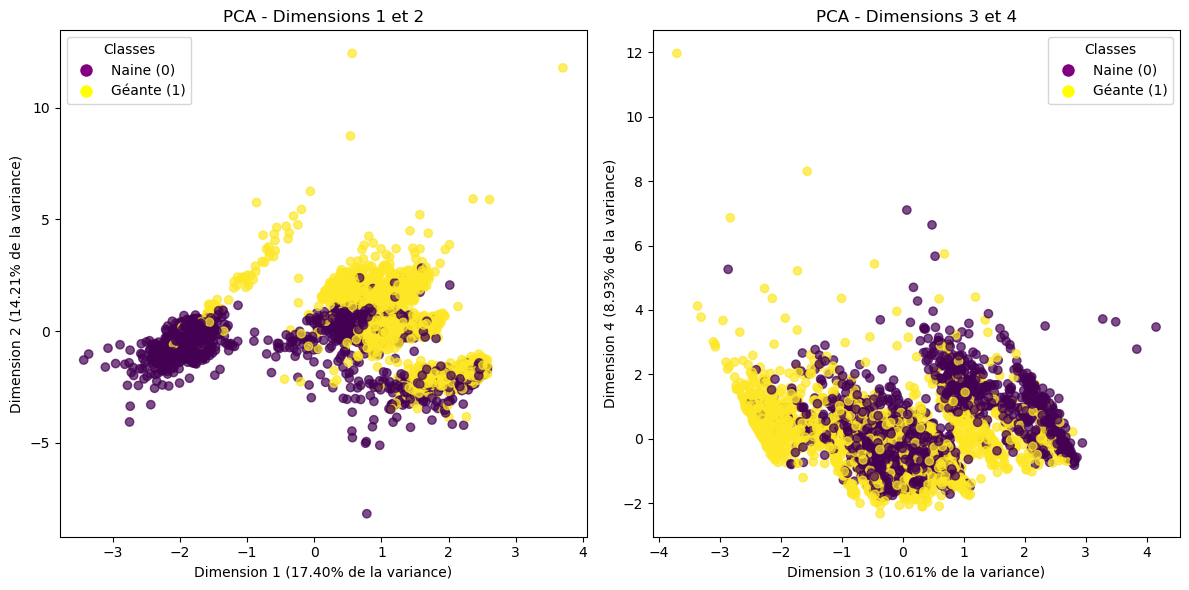

In [15]:
# Visualisation des dimensions principales
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Dimensions 1 et 2
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[0].set_title("PCA - Dimensions 1 et 2")
axes[0].set_xlabel(f"Dimension 1 ({pca.explained_variance_ratio_[0]:.2%} de la variance)")
axes[0].set_ylabel(f"Dimension 2 ({pca.explained_variance_ratio_[1]:.2%} de la variance)")

# Dimensions 3 et 4
axes[1].scatter(X_pca[:, 2], X_pca[:, 3], c=y, cmap='viridis', alpha=0.7)
axes[1].set_title("PCA - Dimensions 3 et 4")
axes[1].set_xlabel(f"Dimension 3 ({pca.explained_variance_ratio_[2]:.2%} de la variance)")
axes[1].set_ylabel(f"Dimension 4 ({pca.explained_variance_ratio_[3]:.2%} de la variance)")
axes[1].legend()

# Ajout de la légende pour les deux classes
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Naine (0)'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Géante (1)')]
axes[0].legend(handles=handles, title="Classes")
axes[1].legend(handles=handles, title="Classes")

plt.tight_layout()
plt.show()

### t-SNE

In [16]:
tsne = TSNE(n_components=2, perplexity=30, random_state=RANDOM_SEED)
X_tsne = tsne.fit_transform(X)

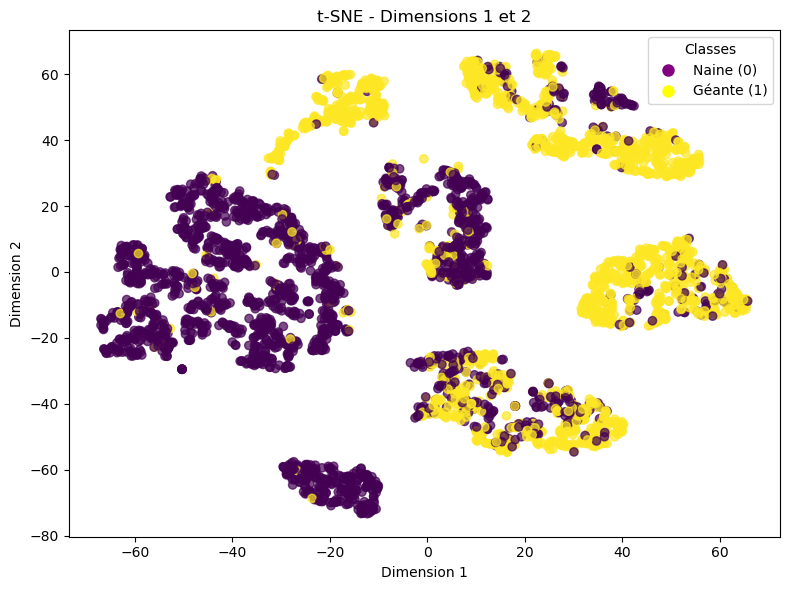

In [17]:
# Créer une figure pour le t-SNE avec deux sous-graphes (1 ligne, 2 colonnes)
plt.subplots(1, 1, figsize=(8, 6))

# Dimensions 1 et 2
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("t-SNE - Dimensions 1 et 2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Dimensions 3 et 4
# axes[1].scatter(X_tsne[:, 2], X_tsne[:, 3], c=y, cmap='viridis', alpha=0.7)
# axes[1].set_title("t-SNE - Dimensions 3 et 4")
# axes[1].set_xlabel("Dimension 3")
# axes[1].set_ylabel("Dimension 4")

# Ajout de la légende pour les deux classes
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Naine (0)'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Géante (1)')]
plt.legend(handles=handles, title="Classes")
plt.legend(handles=handles, title="Classes")

plt.tight_layout()
plt.show()

# 2. Classification
## Séparation des données en jeux d’entrainement/validation et test

In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print(f"Proportion de Géante dans train_val : "
      f"{np.sum(y_train_val) / len(y_train_val):.2%}")
print(f"Proportion de Géante dans test : "
      f"{np.sum(y_test) / len(y_test):.2%}")

Proportion de Géante dans train_val : 43.78%
Proportion de Géante dans test : 46.50%


## Régression logistique multinomiale (softmax)
### Modèle

In [19]:
# Initialiser le modèle
baseline_model = LogisticRegression(multi_class='multinomial')

# Entrainer le modèle
baseline_model.fit(X_train_val, y_train_val)

LogisticRegression(multi_class='multinomial')

### Evaluation

In [20]:
# Évaluation sur le jeu d'entraînement/validation
y_train_val_pred = baseline_model.predict(X_train_val)
accuracy_train_val = accuracy_score(y_train_val, y_train_val_pred)
precision_train_val = precision_score(y_train_val, y_train_val_pred, average='weighted')
recall_train_val = recall_score(y_train_val, y_train_val_pred, average='weighted')
f1_train_val = f1_score(y_train_val, y_train_val_pred, average='weighted')

# Évaluation sur le jeu de test
y_test_pred = baseline_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')


# Affichage des résultats
baseline_results = {
    'Set': ['Train/Validation', 'Test'],
    'Accuracy': [accuracy_train_val, accuracy_test],
    'Precision': [precision_train_val, precision_test],
    'Recall': [recall_train_val, recall_test],
    'F1 Score': [f1_train_val, f1_test]
}
print(pd.DataFrame(baseline_results))

                Set  Accuracy  Precision   Recall  F1 Score
0  Train/Validation   0.90125   0.902811  0.90125  0.901493
1              Test   0.88625   0.887733  0.88625  0.886381


### Cros-validation

In [21]:
gamma_values = np.linspace(000.1, 1, 10)

#### Kernel Polynomial

In [22]:

svc_poly = SVC(kernel='poly', C=5, degree = 3)

grid_search_poly = GridSearchCV(svc_poly,
                                param_grid={'gamma': gamma_values}, 
                                cv=5, 
                                scoring = 'accuracy',
                                verbose = 2)

grid_search_poly.fit(X_train_val, y_train_val)
accuracies_poly = grid_search_poly.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................................gamma=0.1; total time=   0.1s
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.1; total time=   0.1s
[CV] END ..........................................gamma=0.1; total time=   0.1s
[CV] END ..........................................gamma=0.1; total time=   0.1s
[CV] END ..........................................gamma=0.2; total time=   0.1s
[CV] END ..........................................gamma=0.2; total time=   0.1s
[CV] END ..........................................gamma=0.2; total time=   0.2s
[CV] END ..........................................gamma=0.2; total time=   0.1s
[CV] END ..........................................gamma=0.2; total time=   0.2s
[CV] END ..........................gamma=0.30000000000000004; total time=   0.6s
[CV] END ..........................gamma=0.30000

#### Kernel RBF

In [23]:
svc_rbf = SVC(kernel='rbf', C=5)

grid_search_rbf = GridSearchCV(svc_rbf,
                                param_grid={'gamma': gamma_values}, 
                                cv=5, 
                                scoring = 'accuracy',
                                verbose = 2)

grid_search_rbf.fit(X_train_val, y_train_val)
accuracies_rbf = grid_search_rbf.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................gamma=0.30000000000000004; total time=   0.1s
[CV] END ..........................gamma=0.30000

#### Kernel Sigmoid

In [24]:
svc_sigmoid = SVC(kernel='sigmoid', C=5)

grid_search_sigmoid = GridSearchCV(svc_sigmoid,
                                param_grid={'gamma': gamma_values}, 
                                cv=5, 
                                scoring = 'accuracy',
                                verbose = 2)

grid_search_sigmoid.fit(X_train_val, y_train_val)
accuracies_sigmoid= grid_search_sigmoid.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.1; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................................gamma=0.2; total time=   0.0s
[CV] END ..........................gamma=0.30000000000000004; total time=   0.0s
[CV] END ..........................gamma=0.30000

#### Visualisation

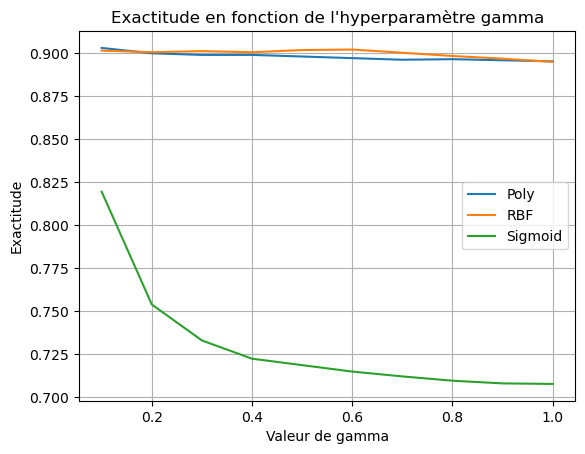

In [25]:
plt.plot(gamma_values, accuracies_poly, label='Poly')
plt.plot(gamma_values, accuracies_rbf, label='RBF')
plt.plot(gamma_values, accuracies_sigmoid, label='Sigmoid')
plt.title("Exactitude en fonction de l'hyperparamètre gamma")
plt.xlabel('Valeur de gamma')
plt.ylabel('Exactitude')
plt.legend()
plt.grid()
plt.show()

#### Meilleur modèle

In [26]:
best_svc = grid_search_poly.best_estimator_

# Évaluation sur le jeu d'entraînement/validation
y_train_val_pred = best_svc.predict(X_train_val)
accuracy_train_val = accuracy_score(y_train_val, y_train_val_pred)
precision_train_val = precision_score(y_train_val, y_train_val_pred, average='weighted')
recall_train_val = recall_score(y_train_val, y_train_val_pred, average='weighted')
f1_train_val = f1_score(y_train_val, y_train_val_pred, average='weighted')

# Évaluation sur le jeu de test
y_test_pred = best_svc.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Affichage des résultats
best_svc_results = {
    'Set': ['Train/Validation', 'Test'],
    'Accuracy': [accuracy_train_val, accuracy_test],
    'Precision': [precision_train_val, precision_test],
    'Recall': [recall_train_val, recall_test],
    'F1 Score': [f1_train_val, f1_test]
}
print(pd.DataFrame(best_svc_results))
print(pd.DataFrame(baseline_results))

                Set  Accuracy  Precision    Recall  F1 Score
0  Train/Validation  0.909062   0.911495  0.909062  0.909335
1              Test  0.885000   0.886869  0.885000  0.885138
                Set  Accuracy  Precision   Recall  F1 Score
0  Train/Validation   0.90125   0.902811  0.90125  0.901493
1              Test   0.88625   0.887733  0.88625  0.886381


# 3. Clustering

In [27]:
cluster_range = range(2, 21)

## Clustering Hiérarchique Agglomératif

In [28]:
calinski_harabasz_scores_cah = []

for k in cluster_range:
    cah_model = AgglomerativeClustering(n_clusters=k)
    cluster_labels =cah_model.fit_predict(X_train_val)

    score = calinski_harabasz_score(X_train_val, cluster_labels)
    calinski_harabasz_scores_cah.append(score)

## GMM

In [29]:
calinski_harabasz_scores_gmm = []

for k in cluster_range:
    gmm_model = GaussianMixture(n_components=k, random_state=RANDOM_SEED)
    cluster_labels = gmm_model.fit_predict(X_train_val)

    score = calinski_harabasz_score(X_train_val, cluster_labels)
    calinski_harabasz_scores_gmm.append(score)

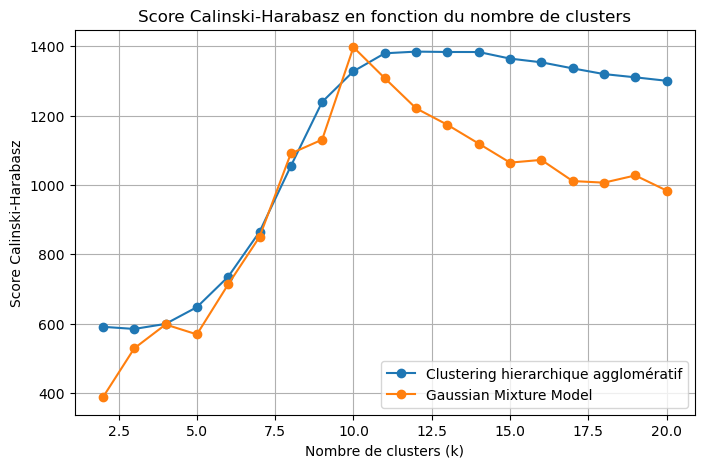

Le nombre optimal de clusters agglomératif est : 12
Le nombre optimal de clusters pour GMM est : 10


In [30]:
plt.figure(figsize=(8, 5))

plt.plot(cluster_range, calinski_harabasz_scores_cah, marker='o', label = 'Clustering hierarchique agglomératif')
plt.plot(cluster_range, calinski_harabasz_scores_gmm, marker='o', label = 'Gaussian Mixture Model')

plt.title("Score Calinski-Harabasz en fonction du nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score Calinski-Harabasz")
plt.legend()
plt.grid(True)
plt.show()

k_best_cah = cluster_range[calinski_harabasz_scores_cah.index(max(calinski_harabasz_scores_cah))]
print(f"Le nombre optimal de clusters agglomératif est : {k_best_cah}")

k_best_gmm = cluster_range[calinski_harabasz_scores_gmm.index(max(calinski_harabasz_scores_gmm))]
print(f"Le nombre optimal de clusters pour GMM est : {k_best_gmm}")

## AMI

In [31]:
best_cah = AgglomerativeClustering(n_clusters=k_best_cah)
y_pred_test_cah = best_cah.fit_predict(X_test)

best_gmm = GaussianMixture(n_components=k_best_gmm)
y_pred_test_gmm = best_gmm.fit_predict(X_test)


# AMI
ami_cah = adjusted_mutual_info_score(y_test, y_pred_test_cah)
ami_gmm = adjusted_mutual_info_score(y_test, y_pred_test_gmm)

# Homogénéité
homog_cah = homogeneity_score(y_test, y_pred_test_cah)
homog_gmm = homogeneity_score(y_test, y_pred_test_gmm)

# Complétude
compl_cah = completeness_score(y_test, y_pred_test_cah)
compl_gmm = completeness_score(y_test, y_pred_test_gmm)

# Affichage des résultats
print(f"Clustering hiérarchique agglomératif (k={k_best_cah}):")
print(f"  AMI : {ami_cah:.3f}")
print(f"  Homogénéité : {homog_cah:.3f}")
print(f"  Complétude : {compl_cah:.3f}")
print("\n")
print(f"Gaussian Mixture Model (k={k_best_gmm}):")
print(f"  AMI : {ami_gmm:.3f}")
print(f"  Homogénéité : {homog_gmm:.3f}")
print(f"  Complétude : {compl_gmm:.3f}")

Clustering hiérarchique agglomératif (k=12):
  AMI : 0.231
  Homogénéité : 0.504
  Complétude : 0.153


Gaussian Mixture Model (k=10):
  AMI : 0.267
  Homogénéité : 0.510
  Complétude : 0.184


In [32]:
# Regression logistique
y_pred_logreg = baseline_model.predict(X)
ami_logreg = adjusted_mutual_info_score(y, y_pred_logreg)
print(f"AMI - Régression Logistique Multinomiale : {ami_logreg:.3f}")

# Classification SVC
y_pred_svc = best_svc.predict(X)
ami_svc = adjusted_mutual_info_score(y, y_pred_svc)
print(f"AMI - SVC (meilleur modèle) : {ami_svc:.3f}")

# Clustering GMM
y_pred_gmm = best_gmm.predict(X)
ami_gmm = adjusted_mutual_info_score(y, y_pred_gmm)
print(f"AMI - Gaussian Mixture Model (k=10) : {ami_gmm:.3f}")

AMI - Régression Logistique Multinomiale : 0.527
AMI - SVC (meilleur modèle) : 0.550
AMI - Gaussian Mixture Model (k=10) : 0.268


# 4. Méthode Mixte

In [48]:
X_tsne_2 = pd.DataFrame(X_tsne[:, :2], columns=['Dimension 1', 'Dimension 2'])

X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_tsne_2, y, test_size=0.2, random_state=RANDOM_SEED)

In [49]:
calinski_harabasz_scores_tsne = []

for k in cluster_range:
    gmm_model_tsne = GaussianMixture(n_components=k, random_state=RANDOM_SEED)
    cluster_labels = gmm_model_tsne.fit_predict(X_train_tsne)

    score = calinski_harabasz_score(X_train_tsne, cluster_labels)
    calinski_harabasz_scores_tsne.append(score)

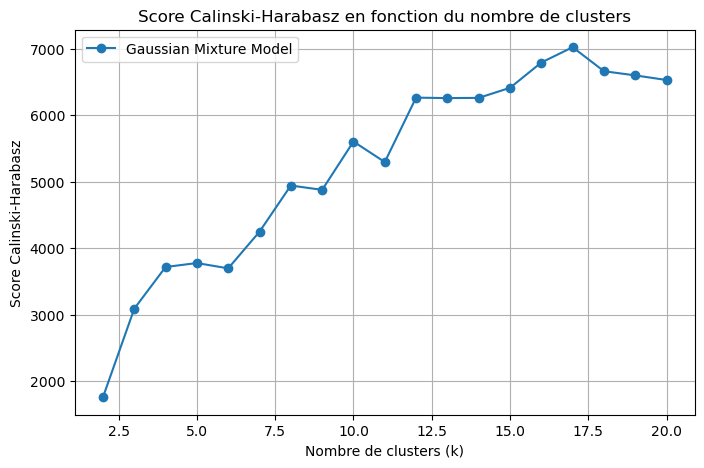

Le nombre optimal de clusters pour GMM est : 17


In [50]:
plt.figure(figsize=(8, 5))

plt.plot(cluster_range, calinski_harabasz_scores_tsne, marker='o', label = 'Gaussian Mixture Model')

plt.title("Score Calinski-Harabasz en fonction du nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score Calinski-Harabasz")
plt.legend()
plt.grid(True)
plt.show()

k_best_tsne = cluster_range[calinski_harabasz_scores_tsne.index(max(calinski_harabasz_scores_tsne))]
print(f"Le nombre optimal de clusters pour GMM est : {k_best_tsne}")

In [77]:
best_gmm_tsne = GaussianMixture(n_components=k_best_tsne)
best_gmm_tsne.fit(X_tsne_2)

GaussianMixture(n_components=17)

## Frontière de décision

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


[]

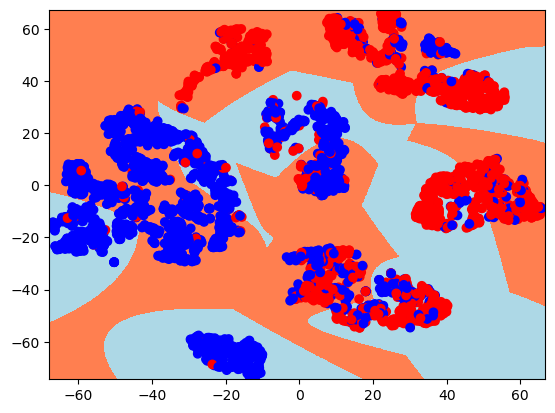

In [79]:
# Nos couleurs
mesh_cmap = ListedColormap(["lightblue", "coral"])
points_cmap = ListedColormap(["blue", "red"])
# La taille de la mesh
mesh_size = 0.1
# Les valeurs numériques des sorties
# outputs_num = outputs.replace(["M", "F", "I"], [0, 1, 2])

# On fixe les limites
x_min, x_max = X_tsne_2['Dimension 1'].min() - 1, X_tsne_2['Dimension 1'].max() + 1
y_min, y_max = X_tsne_2['Dimension 2'].min() - 1, X_tsne_2['Dimension 2'].max() + 1
# On définit notre mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                      np.arange(y_min, y_max, mesh_size))
# On fait les prédictions, que l'on transforme en valeurs numériques
grid_pred = best_gmm_tsne.predict(np.c_[xx.ravel(), yy.ravel()])
grid_pred_num = pd.Series(grid_pred) #.replace(["M", "F", "I"], [0, 1, 2])
grid_pred_num = grid_pred_num.to_numpy().reshape(xx.shape)

# On créée le graphique
fig, ax = plt.subplots()
ax.pcolormesh(xx, yy, grid_pred_num, cmap=mesh_cmap)
ax.scatter(X_tsne_2['Dimension 1'], X_tsne_2['Dimension 2'], c=y, cmap=points_cmap)
plt.plot()